Text(0, 0.5, 'Amplitude')

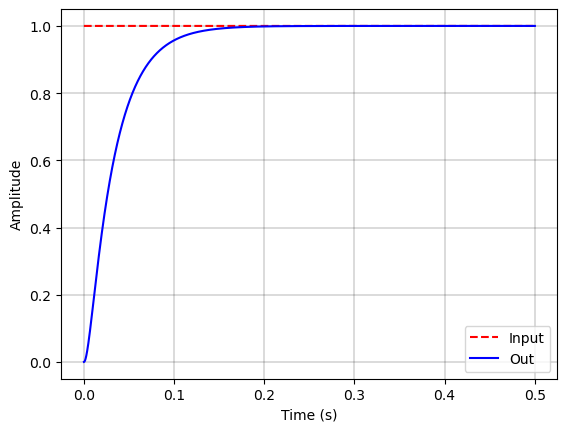

In [1]:
import numpy as np
import control as cnt
import control.matlab  as cntm
import matplotlib.pyplot as plt

# Define the system transfer function
R1 = 10e3
C1 = 1e-6
R2 = 15e3
C2 = 1e-6
num = [1]
den = [(R1*C1*R2*C2), (R1*C1+R1*C2+R2*C2), 1]
sys = cnt.tf(num, den)

# Define the simulation time and input signal
t = np.linspace(0, 0.5, 5000)
u = np.ones(len(t))

t_ol, y_ol = cnt.forced_response(sys, t, u)

# Plot the results
plt.grid(color='k', linestyle='-', linewidth=0.2)
plt.plot(t, u, 'r--', label='Input')
plt.plot(t, y_ol, 'b-', label='Out')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')


In [2]:
# Calcular tiempo de subida
def tiempo_de_subida(t, y):
    y_final = y[-1]
    y_10 = 0.1 * y_final
    y_90 = 0.9 * y_final

    t_10 = next(t[i] for i in range(len(y)) if y[i] >= y_10)
    t_90 = next(t[i] for i in range(len(y)) if y[i] >= y_90)

    return t_90 - t_10

# Calcular el tiempo de subida
tr = tiempo_de_subida(t, y_ol) * 1000
print(f"Tiempo de subida lazo abierto: {tr:.2f}ms")

# tr = tiempo_de_subida(t, y_cl) * 1000
# print(f"Tiempo de subida lazo cerrado: {tr:.2f}ms")

Tiempo de subida lazo abierto: 67.51ms


Text(0, 0.5, 'Amplitude')

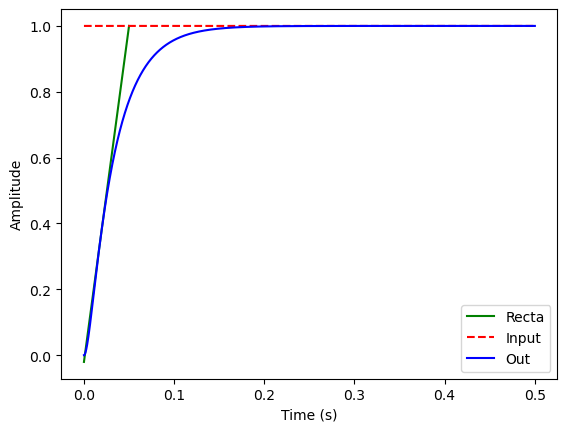

In [3]:
x1 = 0.001
x2 = 0.05
y1 = 0
y2 = 1
# Ecuación de la recta
t1 = np.linspace(0, x2, 5000)
y_r = ((y2-y1)/(x2-x1))*(t1-x1)+y1

plt.plot(t1, y_r, 'g-', label='Recta')
plt.plot(t, u, 'r--', label='Input')
plt.plot(t, y_ol, 'b-', label='Out')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

3.5279999999999996 0.026000000000000002 0.01
135.69230769230765 0.03528


Text(0, 0.5, 'Amplitude')

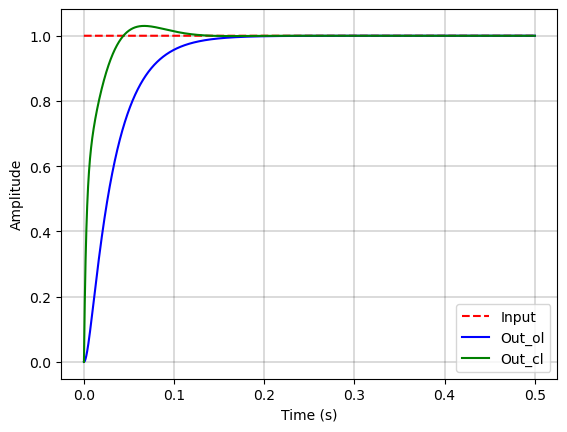

In [4]:
# Ziegler-Nichols Parameters
L = x1
T = x2-x1
# A = B = 1

# PID con Z-N
K  = 1.2*T/L
Ti = 2*L
Td = 0.5*L

K *= 0.06
Ti *= 13
Td *= 20

print(K,Ti,Td)
print(K/Ti, K*Td)

Kp = K
Ki = Kp/Ti
Kd = Kp*Td

pid = cnt.tf([K*Td, K, K/Ti], [1, 0])
pid_sys = cnt.feedback(pid,1)

cl_sys  = cnt.feedback(sys*pid, 1)
t, y_cl = cnt.forced_response(cl_sys, t, u)

# %matplotlib notebook

# Plot the results
plt.grid(color='k', linestyle='-', linewidth=0.2)
plt.plot(t, u, 'r--', label='Input')
plt.plot(t, y_ol, 'b-', label='Out_ol')
plt.plot(t, y_cl, 'g-', label='Out_cl')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

In [5]:
tr = tiempo_de_subida(t, y_ol) * 1000
print(f"Tiempo de subida lazo abierto: {tr:.2f}ms")
print(f"Tiempo de subida deseado: {0.7*tr:.2f}ms")
tr = tiempo_de_subida(t, y_cl) * 1000
print(f"Tiempo de subida lazo cerrado: {tr:.2f}ms")

sobrepico = np.max(y_cl) - np.max(y_ol)
print(f"Sobrepico: {sobrepico*100:.2f}%")

Tiempo de subida lazo abierto: 67.51ms
Tiempo de subida deseado: 47.26ms
Tiempo de subida lazo cerrado: 25.61ms
Sobrepico: 3.01%


In [6]:
h = 0.005
pid_sys = cnt.feedback(pid, 1)

# Convierto el pid al tiempo discreto
hz_1 = cnt.c2d(pid_sys, h, 'zoh')
numz_1, denz_1 = cnt.tfdata(hz_1)

numz_CZ = numz_1[0][0]
denz_CZ = denz_1[0][0]

print(numz_CZ)
print(denz_CZ)


[ 1.         -1.55892256  0.62932468]
[ 1.         -1.45598237  0.52638449]


In [7]:
# Funciones para el control PID

def pid_controller(pid_data: dict) -> dict:
    
    data = pid_data.copy()
    
    p = data['kp'] * (data['b'] * data['r'] - data['y'])
    i = data['future_i']
    d = (data['kd'] / (data['kd'] + data['n'] * data['h'])) * (data['past_d'] - data['n'] * (data['y'] - data['past_y']))
    
    data['u'] = p + i + d
    
    data['future_i'] = i + data['ki'] * data['h'] * (data['r'] - data['y'])
    data['past_d'] = d
    data['past_y'] = data['y']
    
    return data

def pid_controller_response(num: np.ndarray, den: np.ndarray, input: np.ndarray, pid_data: dict) -> np.ndarray:
    
    a = np.array(den).flatten()
    b = np.array(num).flatten()
    
    n_inicial = len(a) - 1
    
    y = np.zeros(len(input) + n_inicial)
    r = np.concatenate((np.zeros(n_inicial), input), axis=None)
    u = np.concatenate((np.zeros(n_inicial), input), axis=None)
    
    data = pid_data.copy()
    
    for k in range(n_inicial, len(r)):

      data['y'] = y[k-1]
      data['r'] = r[k]

      data = pid_controller(data)
    
      u[k] = data['u']

      for m in range(0, len(b)):
        y[k] = y[k] + b[m] * u[k-m]
      
      for n in range(1, len(a)):
        y[k] = y[k] - a[n] * y[k-n]
    
      y[k] = y[k] / a[0]
    
    return y[n_inicial-1:]


def funcion_recurencia(num, den, u):
    
    a = np.array(den).flatten()
    b = np.array(num).flatten()

    n_inicial = len(a) - 1

    y = np.zeros(len(u) + n_inicial)
    u = np.concatenate((np.zeros(n_inicial), u))
    
    for k in range(n_inicial, len(u)):
        
      for m in range(len(b)):
          y[k] += b[m] * u[k-m]
      
      for n in range(1, len(a)):
          y[k] -= a[n] * y[k-n]
      
      y[k] /= a[0]
    
    return y[n_inicial-1:]



Bn -> original :  [0.05779782 0.03924424]
An -> original :  [ 1.         -1.21436117  0.31140322]


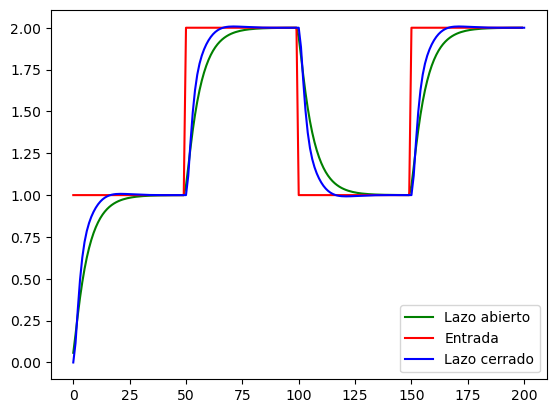

In [8]:
# Define the system transfer function
R1 = 10e3
C1 = 1e-6
R2 = 15e3
C2 = 1e-6
num = [1]
den = [(R1*C1*R2*C2), (R1*C1+R1*C2+R2*C2), 1]
sys = cnt.tf(num, den)
hz_2 = cnt.c2d(sys, h, 'zoh')
numz_2, denz_2 = cnt.tfdata(hz_2)
numz_GZ = numz_2[0][0]
denz_GZ = denz_2[0][0]

print("Bn -> original : ",numz_GZ)
print("An -> original : ",denz_GZ)

input_buffer_GZ = [0] * len(numz_GZ)
output_buffer_GZ = [0] * (len(denz_GZ) - 1)

input_buffer_CZ = [0] * len(numz_CZ)
output_buffer_CZ = [0] * (len(denz_CZ) - 1)

def funcion_recurrencia_GZ(num, den, input_value):
    global input_buffer_GZ, output_buffer_GZ

    # Desplazar valores en el buffer de entrada
    for i in range(len(num) - 1, 0, -1):
        input_buffer_GZ[i] = input_buffer_GZ[i - 1]
    input_buffer_GZ[0] = input_value
    
    output = 0
    
    # Calcular numerador
    for m in range(len(num)):
        output += num[m] * input_buffer_GZ[m]
        # print("num out {} : {}".format(m,output))
    
    # Calcular denominador
    for n in range(1, len(den)):
        output -= den[n] * output_buffer_GZ[n - 1]
        # print("den out {} : {}".format(n,output))
      
    for i in range(len(den) - 2, 0, -1):
        output_buffer_GZ[i] = output_buffer_GZ[i - 1]
    output_buffer_GZ[0] = output
    
    return output

def funcion_recurrencia_CZ(num, den, input_value):
    global input_buffer_CZ, output_buffer_CZ

    # Desplazar valores en el buffer de entrada
    for i in range(len(num) - 1, 0, -1):
        input_buffer_CZ[i] = input_buffer_CZ[i - 1]
    input_buffer_CZ[0] = input_value
    
    output = 0

    # Calcular numerador
    for m in range(len(num)):
        output += num[m] * input_buffer_CZ[m]
    
    # Calcular denominador
    for n in range(1, len(den)):
        output -= den[n] * output_buffer_CZ[n - 1]
      
    for i in range(len(den) - 2, 0, -1):
        output_buffer_CZ[i] = output_buffer_CZ[i - 1]
    output_buffer_CZ[0] = output
    
    return output

# ESTO FUNCIONA
# gz = funcion_recurencia(numz_2, denz_2, u)
# cz = funcion_recurencia(numz_1, denz_1, u)
t = np.linspace(0, 0.2, 50)
u = np.concatenate((-0.5*np.ones(len(t)),0.5*np.ones(len(t)),-0.5*np.ones(len(t)),0.5*np.ones(len(t))))
u += 1.5
sysalone = []
for i in u:
    sysalone.append(funcion_recurrencia_GZ(numz_GZ, denz_GZ, i))

input_buffer_GZ = [0] * len(numz_GZ)
output_buffer_GZ = [0] * (len(denz_GZ) - 1)

# a0 = 0.9584
# a1 = -1.21
# a2 = 0.388
# b0 = 0.04481
# b1 = 0.049

# iden_num = [b0, b1]
# iden_den = [a0 ,a1, a2]
# print("Bn -> identificada : ",iden_num)
# print("An -> identificada : ",iden_den)
# identificacion = []
# for i in u:
#     identificacion.append(funcion_recurrencia_GZ(iden_num, iden_den, i*1.7))

input_buffer_GZ = [0] * len(numz_GZ)
output_buffer_GZ = [0] * (len(denz_GZ) - 1)

input_buffer_CZ = [0] * len(numz_CZ)
output_buffer_CZ = [0] * (len(denz_CZ) - 1)

y_sys = [0]
y_pid = []
for i, value in enumerate(u):
    error = 2*value-y_sys[i]
    pid_output = funcion_recurrencia_CZ(numz_CZ, denz_CZ, error)
    y_pid.append(pid_output)
    system_output = funcion_recurrencia_GZ(numz_GZ, denz_GZ, pid_output)
    y_sys.append(system_output)

plt.plot(sysalone, color = 'green', label='Lazo abierto')
plt.plot(u, color = 'red', label = "Entrada")
plt.plot(y_sys, color = 'blue',label="Lazo cerrado")
plt.legend()
# plt.plot(identificacion, color = 'black')



Text(0, 0.5, 'Amplitude')

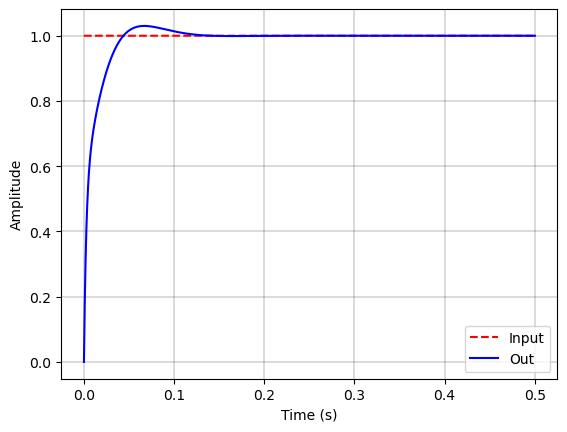

In [9]:
systotal = sys*pid

t = np.linspace(0, 0.5, 5000)
u = np.ones(len(t))

cl_fed = cnt.feedback(sys*pid,1)
t_ol, y_ol = cnt.forced_response(cl_fed, t, u)

# Plot the results
plt.grid(color='k', linestyle='-', linewidth=0.2)
plt.plot(t, u, 'r--', label='Input')
plt.plot(t_ol, y_ol, 'b-', label='Out')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

